# Example CLOC Simulation

In [28]:
#if previously used Brian objects are preventing simulation
%reset -f

In [29]:
from brian2 import *
from clocsim.base import CLOCSimulator

import matplotlib.pyplot as plt

## Set up network

In [33]:
# a group to record from, receiving Poisson input
recording_group = NeuronGroup(100, '''
            dv/dt = -v / tau : volt
            tau: second''',
        threshold='v>-50*mV',
        reset='v=-70*mV'
)
recording_group.tau = 10*ms

input_group = PoissonGroup(100, np.arange(100)*Hz + 10*Hz)

S = Synapses(input_group, recording_group, on_pre='v+=0.1*mV')
S.connect(j='i')

## a group to control
control_group = NeuronGroup(100, '''dv/dt = -v / tau : volt
                                    tau: second''',
                            threshold='v>-50*mV',
                            reset='v=-70*mV')
control_group.tau = 11*ms

state_mon = StateMonitor(control_group, 'v', record=True)
spike_mon = SpikeMonitor(control_group, variables=['v'])

print("Recorded population's equations:")
recording_group.user_equations

Recorded population's equations:


dv/dt = -v/tau : volt
tau : second


## Run simulation

In [34]:
net = Network(collect())
net.run(500*ms)

INFO       No numerical integration method specified for group 'neurongroup_3', using method 'exact' (took 0.01s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_4', using method 'exact' (took 0.01s). [brian2.stateupdaters.base.method_choice]


(5000,)


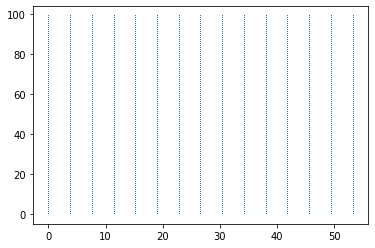

In [49]:
# plt.plot(state_mon.t[0], state_mon.v[0]);
print(state_mon.t.shape)
plt.plot(spike_mon.t[:1500] / ms, spike_mon.i[:1500], ',');